### General Assembly Part-Time Data Science Final Project

### Proposal:
I've decided to investigate the suggested craft beer dataset. My goal is to attempt to predict quality ratings and popularity from the available data. The initial dataset is from Kaggle, which includes a list of beers and a list of breweries, but not ratings. (https://www.kaggle.com/nickhould/craft-cans)

I submitted a request to RateBeer.com for API access, but did not receive a response. As an alternative source for ratings data, I decided to scrape a popular wesbite, Beer Advocate (https://www.beeradvocate.com). This would give me their Beer Advocate score, as well as user ratings and how many users had rated the beer. I also liked this approach because it would provide me a challenge as my first foray into web scraping.

The features would be what was available in the original dataset, and what could be engineered from it, and the targets would be the average user score, and the number of ratings (as a proxy for popularity).

In [1]:
# import statements and configuration
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import requests
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import time
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('fivethirtyeight')

df_beer = pd.read_csv('data/beers.csv')
df_brew = pd.read_csv('data/breweries.csv')

In [2]:
df_beer.head()

,Unnamed: 0,abv,ibu,id,name,style,brewery_id,ounces
0,0,0.050,NaN,1436,Pub Beer,American Pale Lager,408,12.0
1,1,0.066,NaN,2265,Devil's Cup,American Pale Ale (APA),177,12.0
2,2,0.071,NaN,2264,Rise of the Phoenix,American IPA,177,12.0
3,3,0.090,NaN,2263,Sinister,American Double / Imperial IPA,177,12.0
4,4,0.075,NaN,2262,Sex and Candy,American IPA,177,12.0


In [3]:
df_brew.head()

,Unnamed: 0,name,city,state
0,0,NorthGate Brewing,Minneapolis,MN
1,1,Against the Grain Brewery,Louisville,KY
2,2,Jack's Abby Craft Lagers,Framingham,MA
3,3,Mike Hess Brewing Company,San Diego,CA
4,4,Fort Point Beer Company,San Francisco,CA


### Project Brief & Cleaning, Part I

The kaggle data came as two separate datasets, so it was necessar to merge the datasets. This was straightforward since the two datasets shared a brewery id number, so they were mereged without issue.

In [4]:
df = pd.merge(df_beer,
              df_brew,
              left_on = 'brewery_id',
              right_on = 'Unnamed: 0')

df.drop(['Unnamed: 0_x', 'brewery_id', 'Unnamed: 0_y','id'],
        axis = 1,
        inplace = True)

cols = df.columns.tolist()
cols[2] = 'name'
cols[5] = 'brewery'
df.columns = cols

In [5]:
df.head()

,abv,ibu,name,style,ounces,brewery,city,state
0,0.050,NaN,Pub Beer,American Pale Lager,12.0,10 Barrel Brewing Company,Bend,OR
1,0.066,NaN,Devil's Cup,American Pale Ale (APA),12.0,18th Street Brewery,Gary,IN
2,0.071,NaN,Rise of the Phoenix,American IPA,12.0,18th Street Brewery,Gary,IN
3,0.090,NaN,Sinister,American Double / Imperial IPA,12.0,18th Street Brewery,Gary,IN
4,0.075,NaN,Sex and Candy,American IPA,12.0,18th Street Brewery,Gary,IN


In [6]:
# There are only three numeric columns, one of which had a significant amount of missing data. There were also some 
# nulls in the style column
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2410 entries, 0 to 2409
Data columns (total 8 columns):
abv        2348 non-null float64
ibu        1405 non-null float64
name       2410 non-null object
style      2405 non-null object
ounces     2410 non-null float64
brewery    2410 non-null object
city       2410 non-null object
state      2410 non-null object
dtypes: float64(3), object(5)
memory usage: 169.5+ KB


In [7]:
# 'style' I figured would be useful for imputing the missing abv and ibu data. Although there were 99 distinct styles
# 80 styles of which had fewer than 30 in the value counts. I knew this would need to be drastically simplified, 
# but first I thought that type of granularity would be helpful for imputing the missing data.
df[df['style'].isnull()]

,abv,ibu,name,style,ounces,brewery,city,state
566,NaN,NaN,Special Release,NaN,16.0,Cedar Creek Brewery,Seven Points,TX
853,0.060,21.0,Kilt Lifter Scottish-Style Ale,NaN,12.0,Four Peaks Brewing Company,Tempe,AZ
866,0.053,27.0,OktoberFiesta,NaN,12.0,Freetail Brewing Company,San Antonio,TX
1554,NaN,NaN,The CROWLER™,NaN,32.0,Oskar Blues Brewery,Longmont,CO
1555,NaN,NaN,CAN'D AID Foundation,NaN,12.0,Oskar Blues Brewery,Longmont,CO


In [8]:
# Web-based research for these five:
# Special Release, Can'd Aid and the Crowler are a multiple different kinds of beers: they will be dropped
# Kilt Lifter Scottish-Style Ale: Scottish Ale
# OktoberFiesta: Märzen / Oktoberfest
df.drop([566,1554,1555], inplace = True)
df.loc[853,'style'] = 'Scottish Ale'
df.loc[866,'style'] = 'Märzen / Oktoberfest'

In [9]:
# I noticed in my exploration many duplicated entries which would throw off style-grouped means, so before proceeding
# with null value imputation, I'm going to check for duplicates.
# Also, I'm intending to merge some scraped data into the set later. Based on exploratory analysis, the scraped
# data from beer advocate isn't distinguishing different year releases. Thus, years data would be removed from 
# beer names

In [10]:
df.shape[0]

2407

In [11]:
df.drop_duplicates(inplace = True, keep = 'first')
df.shape[0]

2374

In [12]:
# Elimiinating the release years data
df['name'] = df['name'].str.replace(' \(\d{1,4}\)', '')

# true duplicates
df.drop_duplicates(['abv','ibu','name','brewery'],
                   keep = False, 
                   inplace = True)

# by and large, there weren't significant differences in the release year beers, so 
df.drop_duplicates(['name','brewery'],
                   keep = False, 
                   inplace = True)

df.shape[0]

2047

In [13]:
df['abv'] = df.groupby("style")["abv"].transform(lambda x: x.fillna(x.mean()))
df['ibu'] = df.groupby("style")["ibu"].transform(lambda x: x.fillna(x.mean()))

In [14]:
# not all of the ibus could be imputed from grouped means, but with only a few remaining styles, I could simply
# research these to determine appropriate ibu values to impute
df[df['ibu'].isnull()]['style'].value_counts()

Cider                   35
Mead                     5
Shandy                   3
Bière de Garde           3
Rauchbier                2
American Malt Liquor     1
Kristalweizen            1
Braggot                  1
Flanders Red Ale         1
Low Alcohol Beer         1
Name: style, dtype: int64

In [15]:
df.loc[(df['ibu'].isnull()) & (df['style'] == 'Cider'),'ibu'] = 1.0
df.loc[(df['ibu'].isnull()) & (df['style'] == 'Mead'),'ibu'] = 0.0
df.loc[(df['ibu'].isnull()) & (df['style'] == 'Shandy'),'ibu'] = 0.0
df.loc[(df['ibu'].isnull()) & (df['style'] == 'Rauchbier'),'ibu'] = 35.0
df.loc[(df['ibu'].isnull()) & (df['style'] == 'Bière de Garde'),'ibu'] = 25.0
df.loc[(df['ibu'].isnull()) & (df['style'] == 'Flanders Red Ale'),'ibu'] = 40.0
df.loc[(df['ibu'].isnull()) & (df['style'] == 'Kristalweizen'),'ibu'] = 15.0
df.loc[(df['ibu'].isnull()) & (df['style'] == 'American Malt Liquor'),'ibu'] = 15.0
df.loc[(df['ibu'].isnull()) & (df['style'] == 'Braggot'),'ibu'] = 25.0
df.loc[(df['ibu'].isnull()) & (df['style'] == 'Low Alcohol Beer'),'ibu'] = 15.0

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2047 entries, 0 to 2408
Data columns (total 8 columns):
abv        2047 non-null float64
ibu        2047 non-null float64
name       2047 non-null object
style      2047 non-null object
ounces     2047 non-null float64
brewery    2047 non-null object
city       2047 non-null object
state      2047 non-null object
dtypes: float64(3), object(5)
memory usage: 143.9+ KB


### EDA, Part I

Having completed the initial data cleaning, I was prepared to do some initial exploratory analysis, with so few numeric variables at this stage, there wasn't that much to explore.

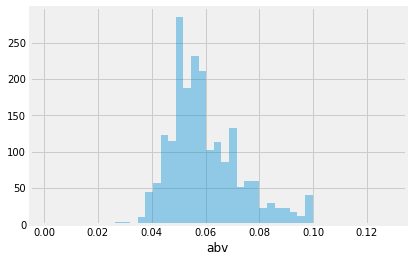

In [17]:
# histogram of abv
sns.distplot(df['abv'], kde = False);

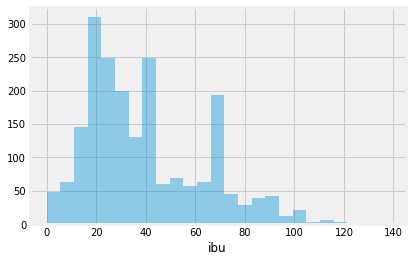

In [18]:
# histogram of ibu
sns.distplot(df['ibu'], kde = False);

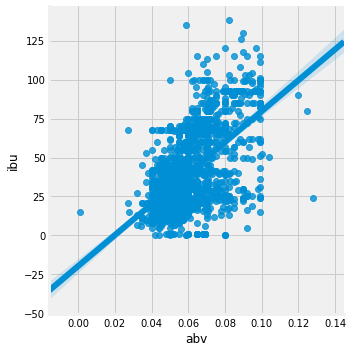

In [19]:
# I became curious to know if there tended to be any relationship between abv and ibu. It turns out there is one
# It's a bit messy, but there is a trend to observe.
sns.lmplot(x = 'abv',
           y = 'ibu',
           data = df);

In [ ]:
# Although there were a few outliers in the above relationship, at this point it isn't clear that these are 
# worth dropping, since we don't know how these variables will relate to each other in any models.

### Additional Data Acquisition

Having not received by this stage a response from my API request to RateBeer, I determined that I would need to procure additional data to perform modeling, by any means. I considered scraping Rate Beer, however some manual searching turned up few results as compared to Beer Advocate, so I thought I would get more mileage out of Beer Advocate anyway.

I took the combined brewery name and beer name from the data that I had, and did some exploratory manual searches with them. What I found was that the search queries were pretty simple, and there were three types of responses:

1) The exact match was found, and would take me to the page of interest
2) Multiple matches were found, in which case I would assume the first result, and follow as though it were response 1.
3) No results were found.

I wrote a simple scraper which accounted for each of these possibilities. It takes the cleaned dataframe as input, loops through it, and passes as searches the brewery and beer name. The returned dataframe would indicate if no result has been found, or whether or not an exact match had been found, and the data I wanted from the site, which was the Score (score), the Average User Rating (avg) and the Number of Ratings (n_ratings), the last of which I thought could be interesting to explore as a proxy for popularity. The return also would have the index to merge the scraped data to the input data.

In [20]:
# First, I needed to reset the index so I wouldn't have trouble merging the data.
df.reset_index(drop = True, inplace = True)

In [ ]:
def ba_scraper(df):
    # instantiate return data frame
    results = pd.DataFrame()
    
    # loop through the data frame
    for i in range(len(df)):
        # instantiate a new row to append to the return data frame
        result_dict = {'index': i,
                       'found': True,
                       'exact': True,
                       'score': None,
                       'avg': None, 
                       'n_ratings': None,
                       'url': None
                      }

        # form search query and submit
        srch = '+'.join(' '.join([df['brewery'][i], df['name'][i]]).split())
        url = 'https://www.beeradvocate.com/search/?q=' + srch + '&qt=beer'
        r = requests.post(url)
        
        # print statements to keep me sane
        print(i, r)
        
        # conditional for query not found 
        if re.search('No results', r.content.decode('utf-8')):
            print('not found\n')
            result_dict['found'] = False
            results = results.append(result_dict, ignore_index = True)
            continue
        
        # conditional for multiple results; take first result path
        if re.search('Found: \d', r.content.decode('utf-8')):
            print('took first result\n')
            result_dict['exact'] = False
            redirect = re.search('(\/beer\/profile\/\d{1,5}\/\d{1,7})',
                                 r.content.decode('utf-8'))
            url = 'https://www.beeradvocate.com' + redirect.group(1)
            r = requests.post(url)
            
        # scraping the score, n_ratings, and user average rating
        score = re.search('Score: (\d{1,3}) ', r.content.decode('utf-8'))
        n_ratings = re.search('Number of ratings for this beer\.\"\>(\d{1,3}|\d{1,3}\,\d{3})\<', r.content.decode('utf-8'))
        avg = re.search('across all ratings for this beer\.\"\>(\d\.\d)', r.content.decode('utf-8'))
        
        # conditionals in case these values were blank
        if score:
            result_dict['score'] = int(score.group(1))
        if avg:
            result_dict['avg'] = float(avg.group(1))
        if n_ratings:
            result_dict['n_ratings'] = int(n_ratings.group(1).replace(',',''))
            
        # also included the source url for QC
        result_dict['url'] = url
        
        
        results = results.append(result_dict, ignore_index = True)
        print(result_dict)
        
        # since this was my only data source, I really didn't want to get my IP blocked, overwhelm the host 
        # or otherwise stymie my data acquisition. thus I added this delay. When I finally got everything working
        # correctly, it would take a little over an hour to submit 2000+ requests
        time.sleep(1)
    
    return results

In [ ]:
scrape_df = ba_scraper(df)

In [ ]:
# After getting it right, I didn't want to have to do that again, so I saved the results offline
# scrape_df.to_csv('./data/ba_scrape.csv')

In [21]:
scrape_df = pd.read_csv('./data/ba_scrape.csv')

In [22]:
# Percentage not found ~ 47.3
scrape_df[(scrape_df['found'] == 0)].shape[0] / scrape_df.shape[0] * 100

47.28871519296531

In [23]:
# Almost 70% returned exact results. I felt that was not bad for my first web scraper. Unfortunately though, a little 
# less than %50 were not found, and would need to be excluded for lacking target data.
# some sample QC into the inexact matches showed ~ 80% success rate, which was also pleasing.
scrape_df[(scrape_df['found'] != 0)]['exact'].value_counts()

1.0    735
0.0    344
Name: exact, dtype: int64

In [24]:
# exclude the data not found
scrape_df = scrape_df[(scrape_df['found'] != 0)]

In [25]:
# merge into the original dataset for further analysis
df_fnl = pd.merge(df,
                  scrape_df,
                  left_index = True,
                  right_index = True)
df_fnl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1079 entries, 1 to 2046
Data columns (total 16 columns):
abv           1079 non-null float64
ibu           1079 non-null float64
name          1079 non-null object
style         1079 non-null object
ounces        1079 non-null float64
brewery       1079 non-null object
city          1079 non-null object
state         1079 non-null object
Unnamed: 0    1079 non-null int64
avg           1066 non-null float64
exact         1079 non-null float64
found         1079 non-null float64
index         1079 non-null float64
n_ratings     1079 non-null float64
score         1006 non-null float64
url           1079 non-null object
dtypes: float64(9), int64(1), object(6)
memory usage: 143.3+ KB


In [26]:
# more observations are eliminated due to lack of target data
df_fnl = df_fnl[~df_fnl['score'].isna()]
df_fnl = df_fnl[~df_fnl['avg'].isna()]

# some scraped data needs to be recast as float / int
df_fnl['avg'] = df_fnl['avg'].astype('float')
df_fnl['n_ratings'] = df_fnl['n_ratings'].astype('int')
df_fnl['score'] = df_fnl['score'].astype('int')

In [27]:
# again, wanted to save my progress to this point
# df_fnl.to_csv('./data/df_final.csv', index = False)

In [28]:
df_fnl = pd.read_csv('./data/df_final.csv')

### Cleaning, Part II

I was finally ready to drop some columns which I did not think would be useful. 'name' and 'brewery' had served their purpose for acquiring additional data. 'city' and 'state' were likely irrelevant relevant, 'found', 'index', and 'url' were no longer need.

With an otherwise clean dataset, it was finally time to simplify 'style' into potentially useful variables.

In [29]:
df_fnl.head()

,abv,ibu,name,style,ounces,brewery,city,state,Unnamed: 0,avg,exact,found,index,n_ratings,score,url
0,0.066,41.850467,Devil's Cup,American Pale Ale (APA),12.0,18th Street Brewery,Gary,IN,1,3.9,1.0,1.0,1.0,112,87,https://www.beeradvocate.com/search/?q=18th+St...
1,0.071,67.711297,Rise of the Phoenix,American IPA,12.0,18th Street Brewery,Gary,IN,2,4.1,1.0,1.0,2.0,61,90,https://www.beeradvocate.com/search/?q=18th+St...
2,0.090,92.645161,Sinister,American Double / Imperial IPA,12.0,18th Street Brewery,Gary,IN,3,4.1,1.0,1.0,3.0,183,92,https://www.beeradvocate.com/search/?q=18th+St...
3,0.075,67.711297,Sex and Candy,American IPA,12.0,18th Street Brewery,Gary,IN,4,3.9,1.0,1.0,4.0,201,89,https://www.beeradvocate.com/search/?q=18th+St...
4,0.077,33.750000,Black Exodus,Oatmeal Stout,12.0,18th Street Brewery,Gary,IN,5,4.1,0.0,1.0,5.0,137,90,https://www.beeradvocate.com/beer/profile/3104...


In [30]:
df_fnl.drop(['name', # insufficient value counts
             'brewery', # insufficient value counts
             'city', # insufficient value counts
             'state', # sufficient value counts for some, but questionable value
             'found', # 0 variance
             'index', # garbage data
             'Unnamed: 0', # garbage data
             'url'], # no longer used
            axis = 1, 
            inplace = True)

In [31]:
# style contained two types of keywords I thought would be interesting, one was regional, as seen here.
locs = ['Engl',
        'Belg',
        'America',
        'Scot',
        'Munic',
        'Berlin']

for l in locs:
    print(l, df_fnl[df_fnl['style'].str.contains(l)].shape[0])

Engl 32
Belg 34
America 596
Scot 11
Munic 11
Berlin 8


In [32]:
# The other was the type of beer.
styles = ['Ale',
          'APA',
          'IPA',
          'Lager',
          'Pils',
          'Cider',
          'Stout',
          'wine',
          'beer',
          'bier',
          'imperial',
          'Kölsch',
          'Porter',
          'Märzen',
          'Gose',
          'tripel',
          'bock',
          'Bière',
          'Bock',
          'Hefeweizen']

for s in styles:
    print(s, df_fnl[df_fnl['style'].str.contains(s,case = False)].shape[0])

Ale 416
APA 97
IPA 235
Lager 56
Pils 36
Cider 3
Stout 55
wine 5
beer 38
bier 46
imperial 49
Kölsch 17
Porter 36
Märzen 13
Gose 7
tripel 5
bock 6
Bière 2
Bock 6
Hefeweizen 14


In [33]:
# I binarized style on the basis of the presence of those keywords if they numbered greater than 30
df_fnl['America'] = np.where(df_fnl['style'].str.contains('America|APA'), 1, 0)
df_fnl['English'] = np.where(df_fnl['style'].str.contains('Engl'), 1, 0)
df_fnl['Belgian'] = np.where(df_fnl['style'].str.contains('Belg'), 1, 0)

df_fnl['ale'] = np.where(df_fnl['style'].str.contains('ale|apa|ipa', case = False), 1, 0)
df_fnl['lager'] = np.where(df_fnl['style'].str.contains('lager', case = False), 1, 0)
df_fnl['pils'] = np.where(df_fnl['style'].str.contains('pils', case = False), 1, 0)
df_fnl['stout'] = np.where(df_fnl['style'].str.contains('stout', case = False), 1, 0)
df_fnl['beer'] = np.where(df_fnl['style'].str.contains('beer|bier|Bière', case = False), 1, 0)
df_fnl['porter'] = np.where(df_fnl['style'].str.contains('porter', case = False), 1, 0)
df_fnl['imperial'] = np.where(df_fnl['style'].str.contains('imperial', case = False), 1, 0)

df_fnl.drop('style',axis = 1, inplace = True)
df_fnl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 17 columns):
abv          1001 non-null float64
ibu          1001 non-null float64
ounces       1001 non-null float64
avg          1001 non-null float64
exact        1001 non-null float64
n_ratings    1001 non-null int64
score        1001 non-null int64
America      1001 non-null int64
English      1001 non-null int64
Belgian      1001 non-null int64
ale          1001 non-null int64
lager        1001 non-null int64
pils         1001 non-null int64
stout        1001 non-null int64
beer         1001 non-null int64
porter       1001 non-null int64
imperial     1001 non-null int64
dtypes: float64(5), int64(12)
memory usage: 133.0 KB


### EDA, Part 2 and Modeling Preparation

In [34]:
# looking for highly correlated variables to remove
df_corr = pd.DataFrame(df_fnl.corr().abs().unstack().sort_values(ascending = False))
df_corr.columns = ['corr']
df_corr[df_corr['corr'] < 1]

,,corr
avg,score,0.956215
score,avg,0.956215
abv,ibu,0.556142
ibu,abv,0.556142
ale,America,0.520623
America,ale,0.520623
ibu,America,0.481042
America,ibu,0.481042
imperial,ibu,0.476266
ibu,imperial,0.476266


In [35]:
# I noticed that avg and score were very highly correlated. 
# BA's score methodology is simply the percentage of ratings which were above 3.75 out of 5.
# With such a tight relationship, it was clear one would go, which I decided would be 'score', since I felt 
# BA's methodology meant that information was being lost
df_fnl.drop('score',axis = 1, inplace = True)

In [36]:
df_fnl[['abv','ibu','avg','n_ratings']].describe()

,abv,ibu,avg,n_ratings
count,1001.000000,1001.000000,1001.000000,1001.000000
mean,0.060103,40.024008,3.671229,527.962038
std,0.013668,23.802254,0.304025,1485.123932
min,0.027000,0.000000,1.900000,10.000000
25%,0.050000,21.027027,3.500000,50.000000
50%,0.057000,33.750000,3.700000,129.000000
75%,0.068000,57.800000,3.800000,386.000000
max,0.125000,138.000000,4.700000,15243.000000


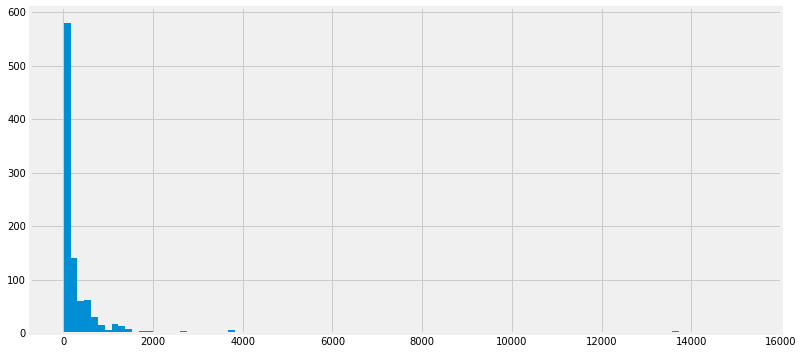

In [37]:
# of the non-binary variables, n_ratings was the only standout which seemed to require additional intervention
df_fnl['n_ratings'].hist(bins = 100, figsize = (12,6));

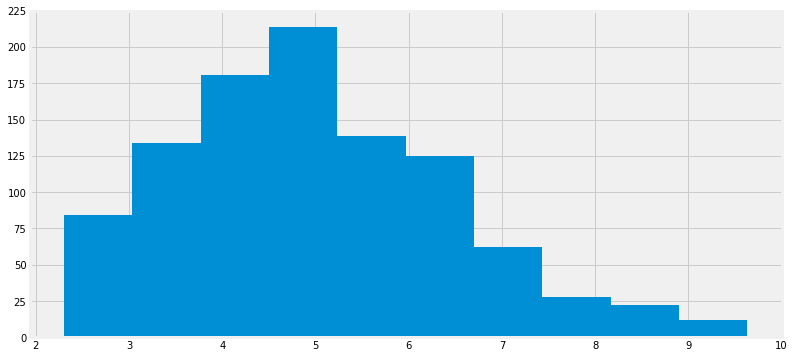

In [38]:
# with severely right-skewed data, and non-negative values, log transformation seemed the most appropriate
np.log(df_fnl['n_ratings']).hist(figsize = (12,6));

In [39]:
df_fnl['n_ratings'] = np.log(df_fnl['n_ratings'])
df_fnl['n_ratings'].describe()

count    1001.000000
mean        4.986252
std         1.466504
min         2.302585
25%         3.912023
50%         4.859812
75%         5.955837
max         9.631876
Name: n_ratings, dtype: float64

### Modeling

I decided to leverage Pipelines and GridSearch so that I could efficiently test Ridge and Lasso linear models, as well as Random Forest Regressors.

The X1 model is my attempt to model the 'avg' rating, and the X2 model is the attempt to predict 'n_ratings'.

In [40]:
# identifying the columns of interst
X1_cols = df_fnl.columns[df_fnl.columns != 'avg']
X2_cols = df_fnl.columns[df_fnl.columns != 'n_ratings']

# copying to more conviently model two different target variables
X1 = df_fnl[X1_cols]
y1 = df_fnl['avg']
X2 = df_fnl[X2_cols]
y2 = df_fnl['n_ratings']

In [41]:
# instantiating the models
lr = LinearRegression()
ss = StandardScaler()
lass = Lasso()
rr = Ridge()
rf = RandomForestRegressor()

# creating three pipes and param grids to feed into GridSearchCV
pipe1 = Pipeline([('ss', ss), ('lasso', lass)])
pipe2 = Pipeline([('ss', ss), ('ridge', rr)])
pipe3 = Pipeline([('ss', ss), ('rf', rf)])

param_grid1 = {'lasso__alpha': np.logspace(-3, 1, 200)}
param_grid2 = {'ridge__alpha': np.logspace(-6, 6, 200)}
param_grid3 = {'rf__max_features': [1,2,0.5,'sqrt','log2'],
               'rf__min_samples_leaf': [1,2,3,5,10],
               'rf__n_estimators': [1,5,10,25,100,1000]}

grid1 = GridSearchCV(estimator=pipe1, param_grid=param_grid1, cv=8)
grid2 = GridSearchCV(estimator=pipe2, param_grid=param_grid2, cv=8)
grid3 = GridSearchCV(estimator=pipe3, param_grid=param_grid3, cv=8)

#### Baseline Score: 'avg'

Since this isn't part of a competition, I need some kind of baseline for comparison. For this I used a simple Linear Regression model.

In [42]:
# standardizing the inputs for the linear model
X1_std = (X1 - X1.mean()) / X1.std()
X2_std = (X2 - X2.mean()) / X2.std()

In [43]:
lr.fit(X1_std, y1)
lr.score(X1_std, y1)

0.3129802793457712

In [44]:
coeffs1 = pd.DataFrame({
    'feature': X1.columns,
    'LR1 Weight': lr.coef_
}).sort_values(by='LR1 Weight', ascending=False)
coeffs1

,feature,LR1 Weight
4,n_ratings,0.077622
0,abv,0.067751
1,ibu,0.053347
2,ounces,0.033090
13,porter,0.030862
11,stout,0.018289
6,English,0.013936
7,Belgian,0.008892
14,imperial,0.001271
12,beer,0.000793


#### Predictions: 'avg'

In [45]:
grid1.fit(X1, y1)

GridSearchCV(cv=8, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'lasso__alpha': array([1.00000e-03, 1.04737e-03, ..., 9.54772e+00, 1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [46]:
grid1_results = pd.DataFrame(grid1.cv_results_)
grid1_results[grid1_results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,mean_train_score,std_train_score
37,0.002747,0.000207,0.000884,0.000123,0.00554266,{'lasso__alpha': 0.005542664520663107},0.271723,0.068977,0.264059,0.300683,...,0.312666,0.332891,0.312972,0.298048,0.330456,0.322107,0.274432,0.317177,0.312594,0.017715


In [47]:
# LR1 Baseline: 0.3129802793457712
lass.set_params(alpha = 0.005542664520663107)
lass.fit(X1, y1)
lass.score(X1, y1)

0.2515044343353463

In [48]:
grid2.fit(X1, y1)

GridSearchCV(cv=8, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'ridge__alpha': array([1.00000e-06, 1.14895e-06, ..., 8.70359e+05, 1.00000e+06])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [49]:
grid2_results = pd.DataFrame(grid2.cv_results_)
grid2_results[grid2_results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,mean_train_score,std_train_score
139,0.002519,0.000163,0.000786,0.000093,240.94,{'ridge__alpha': 240.9403560239527},0.261511,0.090184,0.278695,0.277013,...,0.309374,0.328086,0.308356,0.294908,0.324857,0.317871,0.271385,0.312604,0.30843,0.017025


In [50]:
#LR1 Baseline: 0.3129802793457712
rr.set_params(alpha = 240.9403560239527)
rr.fit(X1, y1)
rr.score(X1, y1)

0.25070575624389135

In [51]:
grid3.fit(X1, y1)

GridSearchCV(cv=8, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=No...='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'rf__max_features': [1, 2, 0.5, 'sqrt', 'log2'], 'rf__min_samples_leaf': [1, 2, 3, 5, 10], 'rf__n_estimators': [1, 5, 10, 25, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [52]:
grid3_results = pd.DataFrame(grid3.cv_results_)
grid3_results[grid3_results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__max_features,param_rf__min_samples_leaf,param_rf__n_estimators,params,split0_test_score,split1_test_score,...,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,mean_train_score,std_train_score
137,0.726971,0.010427,0.046455,0.003125,log2,3,1000,"{'rf__max_features': 'log2', 'rf__min_samples_...",0.273321,0.147761,...,0.57994,0.580845,0.575723,0.568533,0.576635,0.574399,0.539301,0.570588,0.570746,0.012515


In [53]:
# LR1 Baseline: 0.3129802793457712
rf.set_params(max_features = 'sqrt',
              min_samples_leaf = 5,
              n_estimators = 100)
rf.fit(X1, y1)
rf.score(X1, y1)

0.47567689916935296

In [54]:
rf1_features = pd.DataFrame({'feature': X1_cols,
                             'rf1_importance': rf.feature_importances_}).sort_values('rf1_importance',
                                                                                    ascending = False)
rf1_features

,feature,rf1_importance
0,abv,0.277523
4,n_ratings,0.249222
1,ibu,0.205782
3,exact,0.077150
2,ounces,0.054229
9,lager,0.037225
14,imperial,0.029387
5,America,0.017777
8,ale,0.013743
11,stout,0.009352


#### Baseline Score: 'n_ratings'

In [55]:
lr.fit(X2_std, y2)
lr.score(X2_std, y2)

0.22436820589026207

In [56]:
coeffs2 = pd.DataFrame({
    'feature': X2.columns,
    'LR2 Weight': lr.coef_
}).sort_values(by='LR2 Weight', ascending=False)
coeffs2

,feature,LR2 Weight
3,exact,0.422714
1,ibu,0.085726
14,imperial,0.055042
5,America,0.014789
12,beer,-0.022490
9,lager,-0.040279
8,ale,-0.049190
6,English,-0.057353
10,pils,-0.086123
0,abv,-0.089009


#### Predictions: 'n_ratings'

In [57]:
grid1.fit(X2, y2)

GridSearchCV(cv=8, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=0.005542664520663107, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'lasso__alpha': array([1.00000e-03, 1.04737e-03, ..., 9.54772e+00, 1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [58]:
grid1_results = pd.DataFrame(grid1.cv_results_)
grid1_results[grid1_results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,mean_train_score,std_train_score
81,0.002453,0.000121,0.000761,0.000017,0.0424757,{'lasso__alpha': 0.04247571552536898},0.089106,0.016864,0.276572,0.349681,...,0.22887,0.239857,0.201199,0.178429,0.251544,0.215995,0.207323,0.208209,0.216428,0.021689


In [59]:
# LR2 Baseline: 0.22436820589026207
lass.set_params(alpha = 0.04247571552536898)
lass.fit(X2, y2)
lass.score(X2, y2)

0.18882034334501574

In [60]:
grid2.fit(X2, y2)

GridSearchCV(cv=8, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=240.9403560239527, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'ridge__alpha': array([1.00000e-06, 1.14895e-06, ..., 8.70359e+05, 1.00000e+06])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [61]:
grid2_results = pd.DataFrame(grid2.cv_results_)
grid2_results[grid2_results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,mean_train_score,std_train_score
141,0.002434,0.000032,0.000745,0.000007,318.063,{'ridge__alpha': 318.0625692794119},0.091434,0.038843,0.249798,0.305765,...,0.224349,0.233399,0.19759,0.176312,0.243311,0.208869,0.20164,0.203486,0.211119,0.020173


In [62]:
# LR2 Baseline: 0.22436820589026207
rr.set_params(alpha = 318.0625692794119)
rr.fit(X2, y2)
rr.score(X2, y2)

0.143206652561234

In [63]:
grid3.fit(X2, y2)

GridSearchCV(cv=8, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=No...ors=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'rf__max_features': [1, 2, 0.5, 'sqrt', 'log2'], 'rf__min_samples_leaf': [1, 2, 3, 5, 10], 'rf__n_estimators': [1, 5, 10, 25, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [64]:
grid3_results = pd.DataFrame(grid3.cv_results_)
grid3_results[grid3_results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__max_features,param_rf__min_samples_leaf,param_rf__n_estimators,params,split0_test_score,split1_test_score,...,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,mean_train_score,std_train_score
89,0.770749,0.010888,0.048261,0.014241,0.5,10,1000,"{'rf__max_features': 0.5, 'rf__min_samples_lea...",0.137296,0.15536,...,0.410478,0.400084,0.38821,0.357506,0.404158,0.399564,0.392775,0.389356,0.392766,0.015079


In [65]:
# LR2 Baseline: 0.22436820589026207
rf.set_params(max_features = 0.5,
              min_samples_leaf = 10,
              n_estimators = 100)
rf.fit(X2, y2)
rf.score(X2, y2)

0.3918300467847998

In [66]:
rf2_features = pd.DataFrame({'feature': X2_cols,
                             'rf2_importance': rf.feature_importances_}).sort_values('rf2_importance',
                                                                                    ascending = False)
rf2_features

,feature,rf2_importance
3,avg,0.325069
1,ibu,0.214161
4,exact,0.198277
2,ounces,0.108988
0,abv,0.099153
8,ale,0.021875
5,America,0.014925
9,lager,0.007536
7,Belgian,0.003797
14,imperial,0.002634


### Additional Model Exploration

For both targets, the simple linear model seemed to provide worthwhile baselines, but the Lasso and Ridge models didn't seem to perform well, whereas the hyptertuned Random Forest model appeared to perform significantly better.

Looking at the feature importances in the Random Forest model suggested that I might still be attempting to use variables with questionable value. I decided to investigate both RF models' feature importances in conjunction with the Linear Models to determine if there were any variables which could be eliminated and potentially improve model performance.

In [67]:
rf1 = pd.merge(rf1_features,
               coeffs1,
               left_on = 'feature',
               right_on = 'feature')
rf1

,feature,rf1_importance,LR1 Weight
0,abv,0.277523,0.067751
1,n_ratings,0.249222,0.077622
2,ibu,0.205782,0.053347
3,exact,0.077150,-0.032432
4,ounces,0.054229,0.033090
5,lager,0.037225,-0.027028
6,imperial,0.029387,0.001271
7,America,0.017777,-0.013889
8,ale,0.013743,-0.004171
9,stout,0.009352,0.018289


In [68]:
X1_refined_cols = ['abv',
                   'n_ratings',
                   'ibu',
                   'exact',
                   'ounces',
                   'lager',
                   'America']

X1_refined = X1[X1_refined_cols]

In [69]:
grid3.fit(X1_refined, y1)

GridSearchCV(cv=8, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,...ors=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'rf__max_features': [1, 2, 0.5, 'sqrt', 'log2'], 'rf__min_samples_leaf': [1, 2, 3, 5, 10], 'rf__n_estimators': [1, 5, 10, 25, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [70]:
grid3_results = pd.DataFrame(grid3.cv_results_)
grid3_results[grid3_results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__max_features,param_rf__min_samples_leaf,param_rf__n_estimators,params,split0_test_score,split1_test_score,...,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,mean_train_score,std_train_score
113,0.737489,0.126711,0.057917,0.025215,sqrt,5,1000,"{'rf__max_features': 'sqrt', 'rf__min_samples_...",0.256993,0.15168,...,0.533488,0.535262,0.532287,0.51971,0.536171,0.530421,0.495175,0.524449,0.52587,0.01273


In [71]:
# previous RF score: 0.4652987907490791
rf.set_params(max_features = 2,
              min_samples_leaf = 5,
              n_estimators = 100)
rf.fit(X1, y1)
rf.score(X1, y1)

0.4360440992930339

#### n_ratings

In [72]:
rf2 = pd.merge(rf2_features,
               coeffs2,
               left_on = 'feature',
               right_on = 'feature')
rf2

,feature,rf2_importance,LR2 Weight
0,ibu,0.214161,0.085726
1,exact,0.198277,0.422714
2,ounces,0.108988,-0.290589
3,abv,0.099153,-0.089009
4,ale,0.021875,-0.049190
5,America,0.014925,0.014789
6,lager,0.007536,-0.040279
7,Belgian,0.003797,-0.117799
8,imperial,0.002634,0.055042
9,beer,0.001635,-0.022490


In [73]:
X2_refined_cols = ['ibu',
                   'exact',
                   'ounces',
                   'abv',
                   'ale']

X2_refined = X2[X2_refined_cols]

In [74]:
grid3.fit(X2_refined, y2)

GridSearchCV(cv=8, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, m...ors=100, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'rf__max_features': [1, 2, 0.5, 'sqrt', 'log2'], 'rf__min_samples_leaf': [1, 2, 3, 5, 10], 'rf__n_estimators': [1, 5, 10, 25, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [75]:
grid3_results = pd.DataFrame(grid3.cv_results_)
grid3_results[grid3_results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__max_features,param_rf__min_samples_leaf,param_rf__n_estimators,params,split0_test_score,split1_test_score,...,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,mean_train_score,std_train_score
118,0.062128,0.007637,0.005489,0.001327,sqrt,10,100,"{'rf__max_features': 'sqrt', 'rf__min_samples_...",0.087791,0.184359,...,0.299296,0.278406,0.277143,0.280672,0.30362,0.285714,0.29653,0.286518,0.288487,0.009444


In [76]:
# previous RF score: 0.3962053758712649
rf.set_params(max_features = 'sqrt',
              min_samples_leaf = 10,
              n_estimators = 100)
rf.fit(X2_refined, y2)
rf.score(X2_refined, y2)

0.29071425832798536

In [77]:
rf1

,feature,rf1_importance,LR1 Weight
0,abv,0.277523,0.067751
1,n_ratings,0.249222,0.077622
2,ibu,0.205782,0.053347
3,exact,0.077150,-0.032432
4,ounces,0.054229,0.033090
5,lager,0.037225,-0.027028
6,imperial,0.029387,0.001271
7,America,0.017777,-0.013889
8,ale,0.013743,-0.004171
9,stout,0.009352,0.018289


In [78]:
rf2

,feature,rf2_importance,LR2 Weight
0,ibu,0.214161,0.085726
1,exact,0.198277,0.422714
2,ounces,0.108988,-0.290589
3,abv,0.099153,-0.089009
4,ale,0.021875,-0.049190
5,America,0.014925,0.014789
6,lager,0.007536,-0.040279
7,Belgian,0.003797,-0.117799
8,imperial,0.002634,0.055042
9,beer,0.001635,-0.022490
